In [1]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model
from comp_preprocessing import get_data, select_data

from comp_causalmodel import causal_eval, model, bootstrap_effects, placebo_effects, bootstrap_marginal
from comp_postivitree import learn_rules

import numpy as np
import pandas as pd

from matplotlib_venn import venn2, venn3
%load_ext autoreload
%autoreload 2

In [2]:
folder = '/home/victora/PositivityViolation/'

In [3]:
data = select_data(data_path=folder + 'data/ET_2016_Preprocessed.csv')
data[['treatment', 'outcome']].groupby(['treatment']).mean()

,outcome
treatment,
0.0,0.026316
1.0,0.041880


In [7]:
df = pd.read_csv(folder + 'data/ET_2016_Preprocessed.csv')
df['treatment'].mean(), df['outcome'].mean()

(0.6317757009345795, 0.035940803382663845)

In [172]:
# DATA_PATH = folder + 'data/fp_select1613900028_KE.csv'
# DATA_PATH = folder + 'data/fp_select1613901270_ET.csv'
DATA_PATH = folder + 'data/fp_select1613905911_NG.csv'

DATA_PATH = folder + 'data/fp_select1614008431.csv'
X_df, a, y = get_data(data_path=DATA_PATH, encode=True)

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

strartify_by = (a*2) + y
X_train, X_test, a_train, a_test, y_train, y_test = train_test_split(X_df, a, y, train_size=0.7, test_size=0.3, shuffle=True, \
                                                                     random_state=1, stratify=strartify_by)

test_aucs = []
train_aucs = []

# for n in tqdm(range(1, 500, 20)):

for d in tqdm(range(1, 20, 1)):
#     learner = GradientBoostingClassifier(n_estimators=10, random_state=0, max_depth=d)
    learner = DecisionTreeClassifier(max_features='auto', criterion='entropy', max_depth=d)
    learner.fit(X_train, a_train)

    test_auc = roc_auc_score(a_test, learner.predict_proba(X_test)[:, 1])
    train_auc = roc_auc_score(a_train, learner.predict_proba(X_train)[:, 1]) 

    test_aucs.append(test_auc)
    train_aucs.append(train_auc)
  
    
# from sklearn.externals.joblib import parallel_backend
# search = RandomizedSearchCV(model, param_space, cv=10, n_iter=1000, verbose=1)
# with parallel_backend('dask', scheduler_host='your_scheduler_host:your_port'):
#         search.fit(digits.data, digits.target)

100%|██████████| 19/19 [00:00<00:00, 46.13it/s]


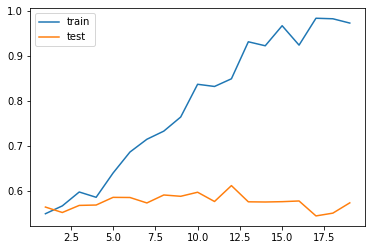

In [202]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20, 1), train_aucs, label='train')
plt.plot(range(1, 20, 1), test_aucs, label='test')
plt.legend()

100%|██████████| 1000/1000 [00:04<00:00, 247.15it/s]


(1.3912397660818716, 0.7136017542610265, 2.351860649731314)

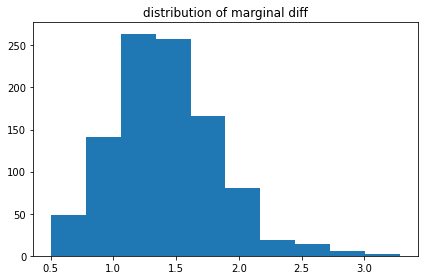

In [35]:
bootstrap_marginal(data_path=DATA_PATH, effect_type='or')

In [116]:
X_df = X_df[~y.isna()]
a = a[~y.isna()]
y = y[~y.isna()]

In [180]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.datasets import load_nhefs
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import DoublyRobustVanilla
from causallib.evaluation import PropensityEvaluator, OutcomeEvaluator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lg = LogisticRegression(penalty="l2", max_iter=3000, class_weight="balanced", random_state=2, solver='lbfgs')
ipw = IPW(make_pipeline(StandardScaler(), lg), truncate_eps=0.05)
std = StratifiedStandardization(make_pipeline(StandardScaler(), lg))

strartify_by = (a*2) + y
X_train, X_test, a_train, a_test, y_train, y_test = train_test_split(X_df, a, y, train_size=0.7, test_size=0.3, shuffle=True, stratify=a)

ipw.fit(X_train, a_train)

IPW(truncate_eps=0.05, use_stabilized=False,
    learner=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=2))]))

In [142]:
ipw.estimate_population_outcome(X_test, a_test, y_test)

Fraction of values being truncated: 0.00156.


1.0   NaN
0.0   NaN
dtype: float64

In [181]:
dr = DoublyRobustVanilla(std, ipw)
dr.fit(X_train[~y_train.isna()], a_train[~y_train.isna()], y_train[~y_train.isna()], refit_weight_model=False)

DoublyRobustVanilla(outcome_covariates=None, outcome_model=StratifiedStandardization(learner=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=2))])), predict_proba=False, weight_covariates=None,
                    weight_model=IPW(truncate_eps=0.05, use_stabilized=False,
    learner=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=3000,
                                    random_state=2))])))

In [182]:
pop_outcomes = dr.estimate_population_outcome(X_test, a_test, y_test)
pop_outcomes.head()

Fraction of values being truncated: 0.00000.


treatment
1.0    0.048352
0.0    0.074352
dtype: float64

In [183]:
effect = dr.estimate_effect(pop_outcomes[1], pop_outcomes[0],
                            effect_types=["diff", "ratio"])
effect

diff    -0.026000
ratio    0.650306
dtype: float64

Fraction of values being truncated: 0.00078.
Fraction of values being truncated: 0.00078.
Fraction of values being truncated: 0.00078.
Fraction of values being truncated: 0.00078.
Fraction of values being truncated: 0.00078.


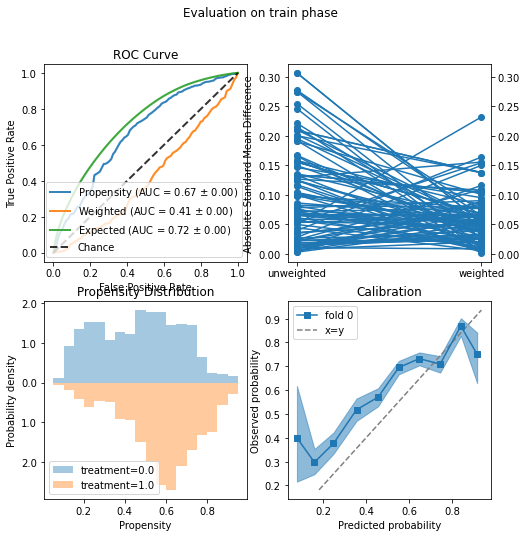

In [179]:
plots=["roc_curve", "covariate_balance_slope", "weight_distribution", "calibration"]
evaluator = PropensityEvaluator(ipw)
evaluations = evaluator.evaluate_simple(X_test, a_test, y_test, plots=plots)

fig = evaluations.plots['covariate_balance_slope'].get_figure()
fig.set_size_inches(8, 8) 

In [ ]:
evaluations, X_test, a_test, y_test = model(data_path=DATA_PATH, encode=True, method='sigmoid')

In [29]:
evaluations.scores.covariate_balance.sort_values(by='weighted', ascending=False).head(3)

abs_smd,weighted,unweighted
covariate,,
v624_6,0.109846,0.096694
v384c,0.095643,0.198208
v536_0,0.092055,0.038633


100%|██████████| 1000/1000 [00:10<00:00, 93.51it/s]


(1.1611034667302107, 0.5981828978138857, 1.994953187401825)

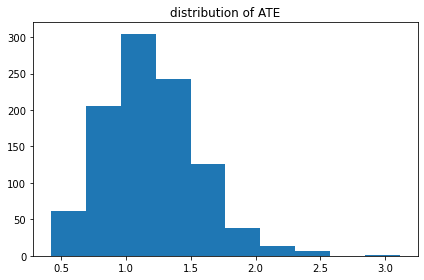

In [37]:
bootstrap_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000, effect_type='or')

100%|██████████| 1000/1000 [01:20<00:00, 12.42it/s]


1.0114778595261114

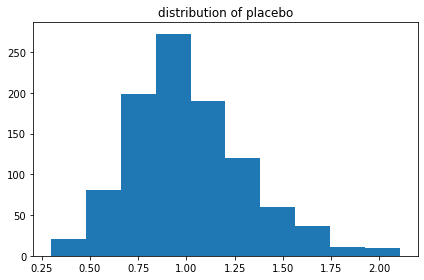

In [38]:
placebo_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000)

In [ ]:
scores, voilating_index, transcript, leaves = learn_rules(data_path=DATA_PATH, var_encoding=folder+ 'data/varencoding-ng.txt', relative=False)

In [25]:
len(voilating_index)/len(X_df)

0.0

In [169]:
ptree_vindex = voilating_index

knn_vindex = []

clr_vindex = []

support_vindex = []

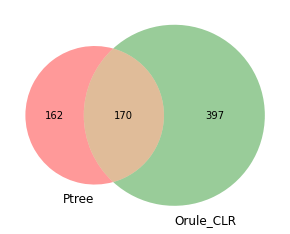

In [170]:
set1 = set(ptree_vindex)
set2 = set(knn_vindex)
set3 = set(clr_vindex)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
venn2([set1, set3], ('Ptree', 'Orule_CLR'), ax=ax)

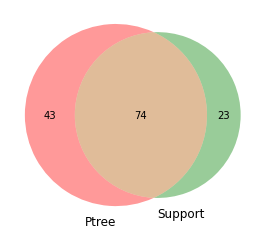

In [33]:
set1 = set(ptree_vindex)
set2 = set(support_vindex)
fig, ax = plt.subplots()
venn2([set1, set2], ('Ptree', 'Support'), ax=ax)

In [33]:
import time
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn3' + timestamp + '.pdf')

In [34]:
overlap_Xdf = X_df.loc[~X_df.index.isin(clr_vindex)]
overlap_adf = a.loc[~X_df.index.isin(clr_vindex)]
overlap_ydf = y.loc[~X_df.index.isin(clr_vindex)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [35]:
concat_df.to_csv(folder + '/data/fp_select_overlap_clr-et-2.csv', index=False)